### Path Integral Physics Theory: U-S Duality Experiment (Harmonic Mean Proxy)

This script aims to experimentally validate the **Grounding Duality** corollary of our path integral physics theory. 

This version reverts to using the **harmonic mean of path energies** as a stable and regular proxy for the Cognitive Internal Energy (U), which is equivalent to the original $H'_{TSE}$ metric. This allows for a clearer visualization of the underlying dynamics. The Cognitive Entropy (S) remains the Shannon entropy of path importances, equivalent to the original $H'_{SIE}$.

The experiment will focus on:

1.  **Observing the Dynamics of U (proxy) and S**: Tracking the evolution of our stable U proxy and S over time for both input (Forward) and output (Backward) grounding modes.
2.  **Validating the U-S Linear Relationship**: Plotting U vs. S to confirm their linear relationship.
3.  **Quantifying the Trends**: Fitting the dynamics with logarithmic functions and reporting R² and p-values.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.datasets import make_moons
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import copy
import warnings
from scipy.optimize import curve_fit
from scipy.stats import linregress

warnings.filterwarnings("ignore", category=FutureWarning)

# --- 1. Experiment Configuration ---
N_SAMPLES = 2000
N_EPOCHS = 5000
BATCH_SIZE = 128
LEARNING_RATE = 0.05
ANALYSIS_SAMPLE_SIZE = 30
LOG_INTERVAL = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# --- 2. MLP Model Definition ---
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.Tanh(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.Tanh(),
            nn.Linear(hidden_dim2, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

In [3]:
# --- 3. Data Preparation ---
X, y = make_moons(n_samples=N_SAMPLES, noise=0.1, random_state=42)
X = torch.FloatTensor(X).to(DEVICE)
y = torch.LongTensor(y).to(DEVICE)

train_dataset = torch.utils.data.TensorDataset(X, y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
# --- 4. Path Integral Physics Theory Analyzer (Original Stable Version) ---
class PathIntegralAnalyzer:
    def __init__(self, model, grounding_mode='output'):
        model_copy = copy.deepcopy(model)
        model_copy.eval()
        self.model = model_copy.to('cpu')
        
        if grounding_mode not in ['input', 'output']:
            raise ValueError("grounding_mode must be 'input' or 'output'")
        self.grounding_mode = grounding_mode
        
        self.graph, self.layer_map = self._build_graph()
        self.grounding_nodes = self._get_grounding_nodes()
        self.hidden_nodes = self._get_hidden_nodes()
        self.memoized_paths = {}

    def _build_graph(self):
        G = nx.DiGraph()
        node_counter = 0
        layer_map = {}
        linear_layers = [l for l in self.model.layers if isinstance(l, nn.Linear)]

        in_features = linear_layers[0].in_features
        layer_map[0] = list(range(node_counter, node_counter + in_features))
        for _ in range(in_features):
            G.add_node(node_counter, layer=0); node_counter += 1

        graph_layer_idx = 1
        for l in linear_layers:
            layer_map[graph_layer_idx] = list(range(node_counter, node_counter + l.out_features))
            for _ in range(l.out_features):
                G.add_node(node_counter, layer=graph_layer_idx); node_counter += 1
            
            weights = torch.abs(l.weight.data.t())
            probs = torch.softmax(weights, dim=1)
            
            for u_local_idx, u_global_idx in enumerate(layer_map[graph_layer_idx - 1]):
                for v_local_idx, v_global_idx in enumerate(layer_map[graph_layer_idx]):
                    prob = probs[u_local_idx, v_local_idx].item()
                    if prob > 1e-9:
                        # The term 'cost' is used here to represent energy for the harmonic mean calculation
                        G.add_edge(u_global_idx, v_global_idx, cost=1.0 - np.log(prob + 1e-9))
            graph_layer_idx += 1
        return G, layer_map

    def _get_grounding_nodes(self):
        if self.grounding_mode == 'input':
            return set(self.layer_map[0])
        else: # 'output'
            max_layer_idx = max(self.layer_map.keys())
            return set(self.layer_map[max_layer_idx])

    def _get_hidden_nodes(self):
        max_layer_idx = max(self.layer_map.keys())
        return [node for node, data in self.graph.nodes(data=True) if data['layer'] not in [0, max_layer_idx]]

    def find_all_paths(self, start, targets):
        # For 'input' grounding, search backward on the graph
        G_search = self.graph.reverse() if self.grounding_mode == 'input' else self.graph
        memo_key = (start, tuple(sorted(list(targets))))
        if memo_key in self.memoized_paths: return self.memoized_paths[memo_key]
        
        paths = []
        for target in targets:
            try:
                for path in nx.all_simple_paths(G_search, source=start, target=target, cutoff=10):
                    cost = sum(G_search.get_edge_data(u, v)['cost'] for u, v in zip(path, path[1:]))
                    paths.append({'path': path, 'cost': cost})
            except (nx.NetworkXNoPath, nx.NodeNotFound):
                continue
        
        self.memoized_paths[memo_key] = paths
        return paths

    def calculate_physics_for_node(self, node):
        paths = self.find_all_paths(node, self.grounding_nodes)
        if not paths:
            return {'U': float('inf'), 'S': float('nan')}

        costs = np.array([p['cost'] for p in paths])
        
        # U: Cognitive Internal Energy (Proxy using harmonic mean of costs/energies)
        conductances = 1.0 / (costs + 1e-9)
        U = 1.0 / np.sum(conductances) if np.sum(conductances) > 0 else float('inf')

        # S: Cognitive Entropy (Shannon Entropy of path importances)
        importances = np.exp(-1.0 * costs)
        probabilities = importances / np.sum(importances) if np.sum(importances) > 0 else np.zeros_like(importances)
        S = -np.sum(probabilities * np.log2(probabilities + 1e-9))
        
        return {'U': U, 'S': S}

    def analyze_network(self, sample_size):
        U_vals, S_vals = [], []
        if not self.hidden_nodes: return float('inf'), float('nan')

        sample_nodes = np.random.choice(self.hidden_nodes, size=min(sample_size, len(self.hidden_nodes)), replace=False)
        for node in sample_nodes:
            physics = self.calculate_physics_for_node(node)
            if np.isfinite(physics['U']) and np.isfinite(physics['S']):
                U_vals.append(physics['U'])
                S_vals.append(physics['S'])
                
        mean_U = np.mean(U_vals) if U_vals else float('inf')
        mean_S = np.mean(S_vals) if S_vals else float('nan')
        
        return mean_U, mean_S

In [5]:
# --- 5. Training and Logging Physical Quantities (U and S) ---
model = SimpleMLP(input_dim=2, hidden_dim1=10, hidden_dim2=7, output_dim=2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

history = {
    'epochs': [],
    'loss': [],
    'U_forward': [], 'S_forward': [], # Forward (input grounding) analysis
    'U_backward': [], 'S_backward': []  # Backward (output grounding) analysis
}

pbar = trange(N_EPOCHS, desc="Training")
for epoch in pbar:
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if epoch % LOG_INTERVAL == 0:
        history['epochs'].append(epoch)
        history['loss'].append(loss.item())
        
        # Forward analysis (Theoretical Basis)
        analyzer_forward = PathIntegralAnalyzer(model, grounding_mode='input')
        U_fwd, S_fwd = analyzer_forward.analyze_network(ANALYSIS_SAMPLE_SIZE)
        history['U_forward'].append(U_fwd)
        history['S_forward'].append(S_fwd)

        # Backward analysis (Engineering Proxy)
        analyzer_backward = PathIntegralAnalyzer(model, grounding_mode='output')
        U_bwd, S_bwd = analyzer_backward.analyze_network(ANALYSIS_SAMPLE_SIZE)
        history['U_backward'].append(U_bwd)
        history['S_backward'].append(S_bwd)
        
        pbar.set_postfix_str(f"Loss:{loss.item():.3f} | U_fwd:{U_fwd:.2f} | U_bwd:{U_bwd:.2f}")

print("Training Complete!")

Training: 100%|██████████| 5000/5000 [03:15<00:00, 25.52it/s, Loss:0.002 | U_fwd:1.24 | U_bwd:0.54]

Training Complete!


C:\Users\Odin\AppData\Local\Temp\ipykernel_5040\3136059038.py:19: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x + 1) + c


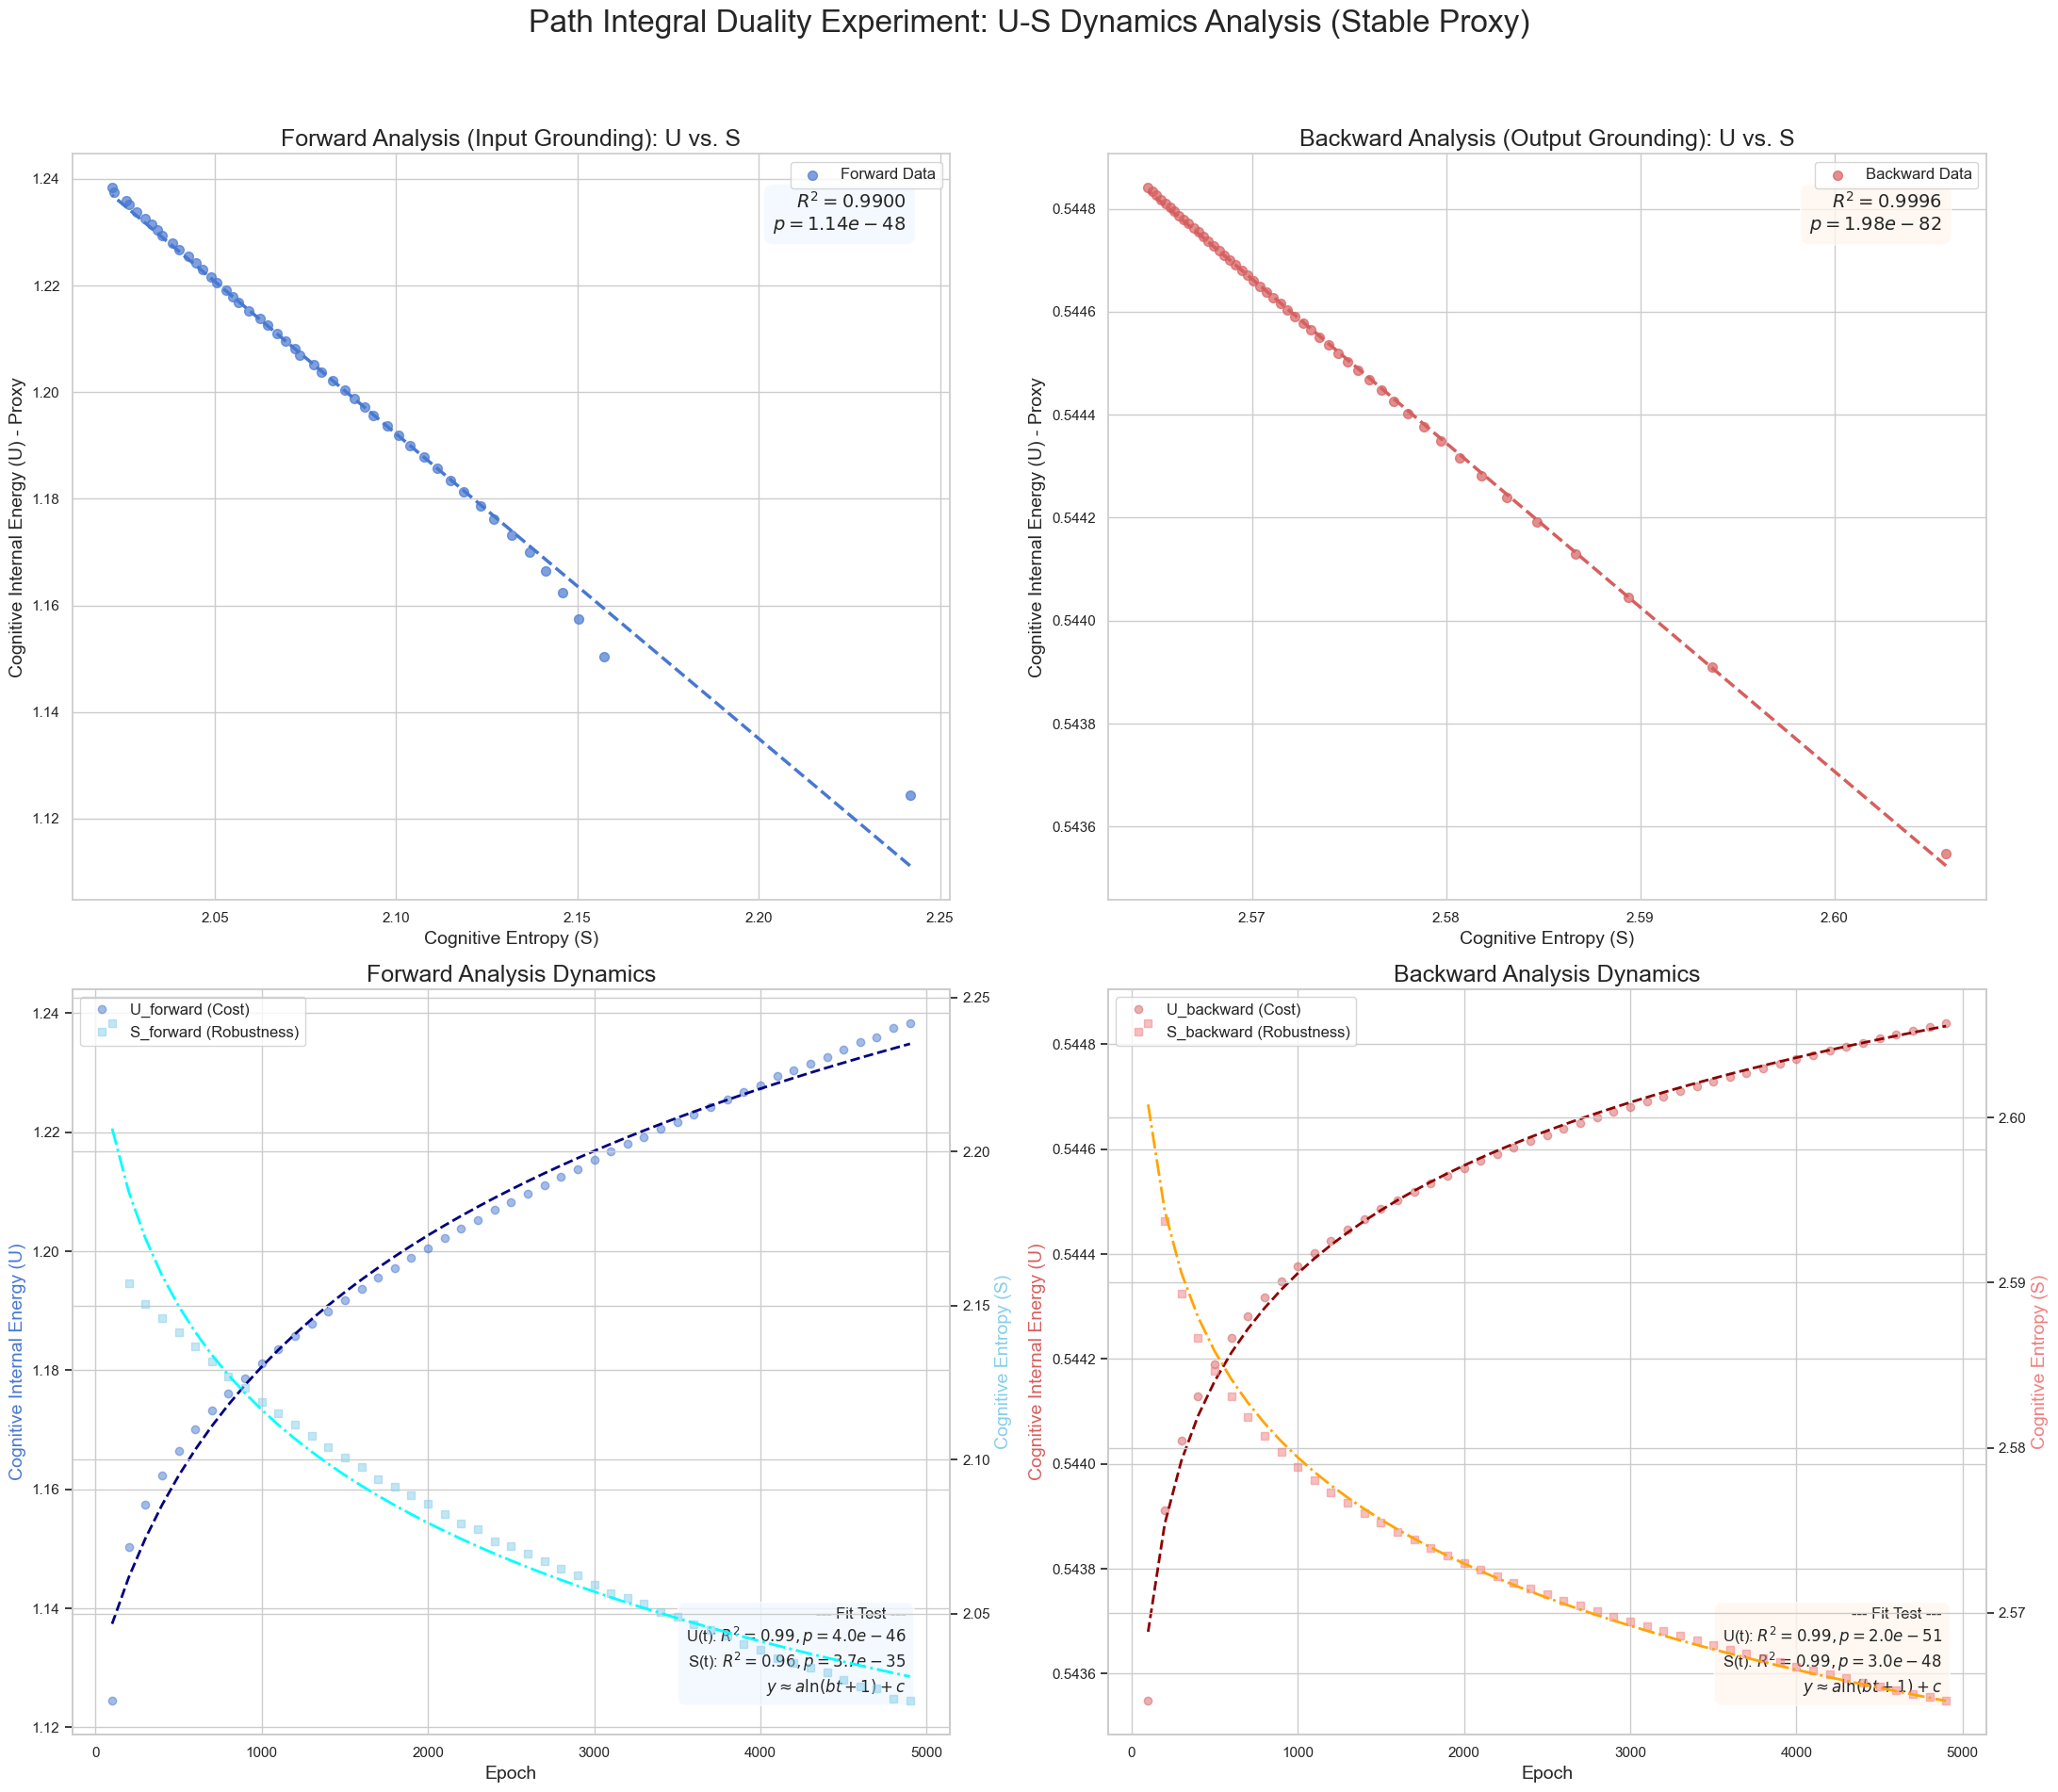

In [6]:
# --- 6. Visualization and Statistical Analysis of Results (Modified) ---
sns.set_theme(style="whitegrid", palette="muted")

fig, axes = plt.subplots(2, 2, figsize=(22, 20))
fig.suptitle('Path Integral Duality Experiment: U-S Dynamics Analysis (Stable Proxy)', fontsize=24, y=0.98)

# --- Data Cleaning ---
epochs = np.array(history['epochs'])
U_fwd = np.array(history['U_forward'])
S_fwd = np.array(history['S_forward'])
U_bwd = np.array(history['U_backward'])
S_bwd = np.array(history['S_backward'])

mask_fwd = np.isfinite(U_fwd) & np.isfinite(S_fwd) & (epochs > 0) # Exclude epoch 0 for log fit
mask_bwd = np.isfinite(U_bwd) & np.isfinite(S_bwd) & (epochs > 0)

# --- Fitting Functions ---
def log_func(x, a, b, c):
    return a * np.log(b * x + 1) + c

# --- Plot 1: U-S Linear Relationship ---
# Forward Analysis
slope_fwd, intercept_fwd, r_fwd, p_fwd, _ = linregress(S_fwd[mask_fwd], U_fwd[mask_fwd])
axes[0, 0].scatter(S_fwd[mask_fwd], U_fwd[mask_fwd], label='Forward Data', color='C0', alpha=0.7, s=50)
axes[0, 0].plot(S_fwd[mask_fwd], intercept_fwd + slope_fwd * S_fwd[mask_fwd], color='C0', linestyle='--', lw=2.5)
axes[0, 0].set_title('Forward Analysis (Input Grounding): U vs. S', fontsize=18)
axes[0, 0].set_xlabel("Cognitive Entropy (S)", fontsize=14)
axes[0, 0].set_ylabel("Cognitive Internal Energy (U) - Proxy", fontsize=14)
axes[0, 0].text(0.95, 0.95, f'$R^2 = {r_fwd**2:.4f}$\n$p = {p_fwd:.2e}$', transform=axes[0, 0].transAxes, fontsize=14, va='top', ha='right', bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))
axes[0, 0].legend(fontsize=12)

# Backward Analysis
slope_bwd, intercept_bwd, r_bwd, p_bwd, _ = linregress(S_bwd[mask_bwd], U_bwd[mask_bwd])
axes[0, 1].scatter(S_bwd[mask_bwd], U_bwd[mask_bwd], label='Backward Data', color='C3', alpha=0.7, s=50)
axes[0, 1].plot(S_bwd[mask_bwd], intercept_bwd + slope_bwd * S_bwd[mask_bwd], color='C3', linestyle='--', lw=2.5)
axes[0, 1].set_title('Backward Analysis (Output Grounding): U vs. S', fontsize=18)
axes[0, 1].set_xlabel("Cognitive Entropy (S)", fontsize=14)
axes[0, 1].set_ylabel("Cognitive Internal Energy (U) - Proxy", fontsize=14)
axes[0, 1].text(0.95, 0.95, f'$R^2 = {r_bwd**2:.4f}$\n$p = {p_bwd:.2e}$', transform=axes[0, 1].transAxes, fontsize=14, va='top', ha='right', bbox=dict(boxstyle='round,pad=0.5', fc='seashell', alpha=0.8))
axes[0, 1].legend(fontsize=12)

# --- Plot 2: Dynamics Over Time with Logarithmic Fit ---
# Forward Dynamics
ax_fwd_U = axes[1, 0]
ax_fwd_S = ax_fwd_U.twinx()
p_fwd_U, = ax_fwd_U.plot(epochs[mask_fwd], U_fwd[mask_fwd], 'o', label='U_forward (Cost)', color='C0', alpha=0.5)
p_fwd_S, = ax_fwd_S.plot(epochs[mask_fwd], S_fwd[mask_fwd], 's', label='S_forward (Robustness)', color='skyblue', alpha=0.5)

u_fwd_stats_text = "U_fwd fit failed"
s_fwd_stats_text = "S_fwd fit failed"

try:
    params_U_fwd, _ = curve_fit(log_func, epochs[mask_fwd], U_fwd[mask_fwd], p0=[1, 0.001, np.min(U_fwd[mask_fwd])], maxfev=5000)
    fit_U_fwd = log_func(epochs[mask_fwd], *params_U_fwd)
    ax_fwd_U.plot(epochs[mask_fwd], fit_U_fwd, '--', color='navy', lw=2)
    _, _, r_u, p_u, _ = linregress(U_fwd[mask_fwd], fit_U_fwd)
    u_fwd_stats_text = f"$R^2={r_u**2:.2f}, p={p_u:.1e}$"
except RuntimeError:
    pass

try:
    params_S_fwd, _ = curve_fit(log_func, epochs[mask_fwd], S_fwd[mask_fwd], p0=[-1, 0.001, np.max(S_fwd[mask_fwd])], maxfev=5000)
    fit_S_fwd = log_func(epochs[mask_fwd], *params_S_fwd)
    ax_fwd_S.plot(epochs[mask_fwd], fit_S_fwd, '-.', color='cyan', lw=2)
    _, _, r_s, p_s, _ = linregress(S_fwd[mask_fwd], fit_S_fwd)
    s_fwd_stats_text = f"$R^2={r_s**2:.2f}, p={p_s:.1e}$"
except RuntimeError:
    pass

ax_fwd_U.set_xlabel('Epoch', fontsize=14)
ax_fwd_U.set_ylabel('Cognitive Internal Energy (U)', color='C0', fontsize=14)
ax_fwd_S.set_ylabel('Cognitive Entropy (S)', color='skyblue', fontsize=14)
ax_fwd_U.set_title('Forward Analysis Dynamics', fontsize=18)
ax_fwd_U.legend(handles=[p_fwd_U, p_fwd_S], loc='best', fontsize=12)
fwd_text = f"--- Fit Test ---\nU(t): {u_fwd_stats_text}\nS(t): {s_fwd_stats_text}\n$y \\approx a \\ln(bt+1)+c$"
ax_fwd_U.text(0.95, 0.05, fwd_text, transform=ax_fwd_U.transAxes, fontsize=12, va='bottom', ha='right', bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))

# Backward Dynamics
ax_bwd_U = axes[1, 1]
ax_bwd_S = ax_bwd_U.twinx()
p_bwd_U, = ax_bwd_U.plot(epochs[mask_bwd], U_bwd[mask_bwd], 'o', label='U_backward (Cost)', color='C3', alpha=0.5)
p_bwd_S, = ax_bwd_S.plot(epochs[mask_bwd], S_bwd[mask_bwd], 's', label='S_backward (Robustness)', color='lightcoral', alpha=0.5)

u_bwd_stats_text = "U_bwd fit failed"
s_bwd_stats_text = "S_bwd fit failed"

try:
    params_U_bwd, _ = curve_fit(log_func, epochs[mask_bwd], U_bwd[mask_bwd], p0=[-1, 0.001, np.max(U_bwd[mask_bwd])], maxfev=5000)
    fit_U_bwd = log_func(epochs[mask_bwd], *params_U_bwd)
    ax_bwd_U.plot(epochs[mask_bwd], fit_U_bwd, '--', color='darkred', lw=2)
    _, _, r_u, p_u, _ = linregress(U_bwd[mask_bwd], fit_U_bwd)
    u_bwd_stats_text = f"$R^2={r_u**2:.2f}, p={p_u:.1e}$"
except RuntimeError:
    pass
    
try:
    params_S_bwd, _ = curve_fit(log_func, epochs[mask_bwd], S_bwd[mask_bwd], p0=[1, 0.001, np.min(S_bwd[mask_bwd])], maxfev=5000)
    fit_S_bwd = log_func(epochs[mask_bwd], *params_S_bwd)
    ax_bwd_S.plot(epochs[mask_bwd], fit_S_bwd, '-.', color='orange', lw=2)
    _, _, r_s, p_s, _ = linregress(S_bwd[mask_bwd], fit_S_bwd)
    s_bwd_stats_text = f"$R^2={r_s**2:.2f}, p={p_s:.1e}$"
except RuntimeError:
    pass

ax_bwd_U.set_xlabel('Epoch', fontsize=14)
ax_bwd_U.set_ylabel('Cognitive Internal Energy (U)', color='C3', fontsize=14)
ax_bwd_S.set_ylabel('Cognitive Entropy (S)', color='lightcoral', fontsize=14)
ax_bwd_U.set_title('Backward Analysis Dynamics', fontsize=18)
ax_bwd_U.legend(handles=[p_bwd_U, p_bwd_S], loc='best', fontsize=12)
bwd_text = f"--- Fit Test ---\nU(t): {u_bwd_stats_text}\nS(t): {s_bwd_stats_text}\n$y \\approx a \\ln(bt+1)+c$"
ax_bwd_U.text(0.95, 0.05, bwd_text, transform=ax_bwd_U.transAxes, fontsize=12, va='bottom', ha='right', bbox=dict(boxstyle='round,pad=0.5', fc='seashell', alpha=0.8))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()